In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
date_start = '2005-01-01'
date_end = '2019-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('XOM')
    limit 100
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

symbol     market_datetime   open
0    XOM 2005-01-03 06:00:00  51.02
1    XOM 2005-01-04 06:00:00  50.34
2    XOM 2005-01-05 06:00:00  49.83
3    XOM 2005-01-06 06:00:00  49.30
4    XOM 2005-01-07 06:00:00  50.12

### Clean data

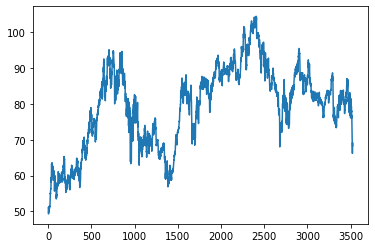

In [3]:
plt.plot(df['open'])
plt.show()

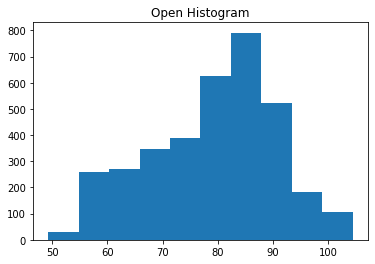

In [4]:
plt.hist(df['open'])
plt.title('Open Histogram')
plt.show()

### Lstm on open data

In [5]:
df['open_min'] = df['open'].rolling(100).min()
df['open_max'] = df['open'].rolling(100).max()

df['target'] = (df['open'] - df['open_min'])/(df['open_max'] - df['open_min'])

df = df[df['target'].notnull()]

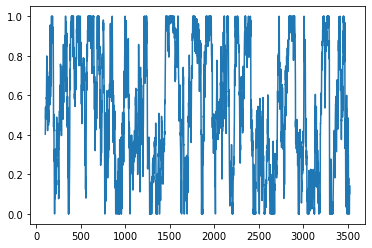

In [6]:
plt.plot(df['target'])
plt.show()

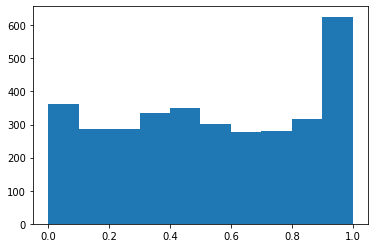

In [7]:
plt.hist(df['target'])
plt.show()

In [8]:
x_temp = df['target'].values

sequence_length = 100

x = []
y = []

for n in range(len(x_temp) - sequence_length - 1):
    x_i = x_temp[n : n + sequence_length]
    y_i = x_temp[n + sequence_length]
    
    x.append(x_i)
    y.append(y_i)

x_arr = np.array(x)
y_arr = np.array(y)

print(len(x_arr))

3324


In [9]:
model = nn_utils.TorchLSTM(train_x=pd.DataFrame(x_arr).head(1000), 
                           train_y=pd.DataFrame(y_arr).head(1000),
                           test_x=pd.DataFrame(x_arr).tail(1000), 
                           test_y=pd.DataFrame(y_arr).tail(1000),
                           n_layers=2,
                           n_epochs=1000,
                           hidden_shape=1000,
                           batch_size=10,
                           dropout=.1,
                           learning_rate=.0001,
                           device='cuda:0')

Epoch  0 Error:  583.8187255859375
Epoch  100 Error:  155.93081665039062
Epoch  200 Error:  88.31156921386719
Epoch  300 Error:  76.84466552734375
Epoch  400 Error:  66.69265747070312
Epoch  500 Error:  63.06676483154297
Epoch  600 Error:  57.235137939453125
Epoch  700 Error:  53.380531311035156
Epoch  800 Error:  46.675907135009766
Epoch  900 Error:  42.956790924072266


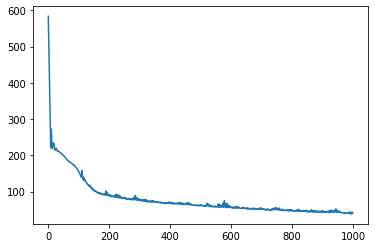

In [10]:
model.execute()

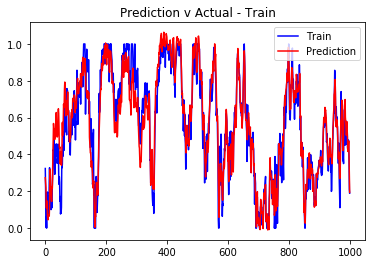

In [11]:
model.plot_prediction_train()

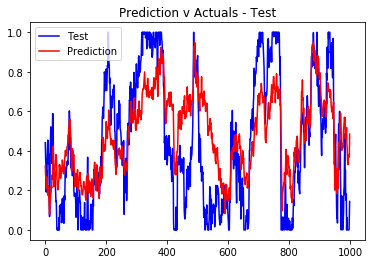

In [12]:
model.plot_prediction_test()

In [13]:
model.reset_network()

In [14]:
test_df = model.test_df
temp = df.tail(1000).reset_index(drop=True)
test_df = test_df.join(temp)
test_df.head()

0         1         2         3         4         5         6  \
0  0.476045  0.381132  0.384324  0.415929  0.300885  0.290771  0.329962   
1  0.381132  0.384324  0.415929  0.300885  0.290771  0.329962  0.413401   
2  0.384324  0.415929  0.300885  0.290771  0.329962  0.413401  0.319848   
3  0.415929  0.300885  0.290771  0.329962  0.413401  0.319848  0.362832   
4  0.300885  0.290771  0.329962  0.413401  0.319848  0.362832  0.369153   

          7         8         9  ...        98        99   actuals  \
0  0.413401  0.319848  0.362832  ...  0.318182  0.362891  0.441133   
1  0.319848  0.362832  0.369153  ...  0.362891  0.441133  0.362146   
2  0.362832  0.369153  0.297092  ...  0.441133  0.362146  0.335320   
3  0.369153  0.297092  0.217893  ...  0.362146  0.335320  0.191791   
4  0.297092  0.217893  0.169591  ...  0.335320  0.191791  0.302239   

   prediction  symbol     market_datetime   open  open_min  open_max    target  
0    0.322897     XOM 2015-01-12 06:00:00  91.24     86.38     99.80  0.362146  
1    0.276337     XOM 2015-01-13 06:00:00  90.88     86.38     99.80  0.335320  
2    0.267158     XOM 2015-01-14 06:00:00  88.95     86.38     99.78  0.191791  
3    0.221817     XOM 2015-01-15 06:00:00  90.43     86.38     99.78  0.302239  
4    0.208553     XOM 2015-01-16 06:00:00  88.98     86.38     99.78  0.194030  

[5 rows x 108 columns]

In [15]:
test_df['prediction_mapped'] = (test_df['prediction'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['actuals_mapped'] = (test_df['actuals'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']

In [16]:
test_df[['open', 'prediction_mapped']].head()

open  prediction_mapped
0  91.24          90.713277
1  90.88          90.088447
2  88.95          89.959917
3  90.43          89.352345
4  88.98          89.174617

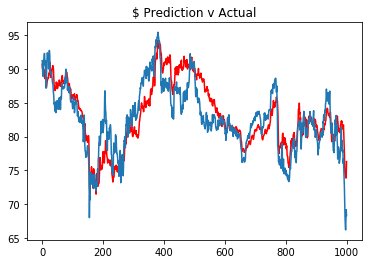

In [17]:
plt.title('$ Prediction v Actual')
plt.plot(test_df['prediction_mapped'], color='r')
plt.plot(test_df['open'])
plt.show()

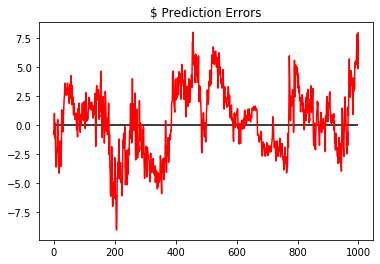

In [18]:
plt.title('$ Prediction Errors')
plt.plot(test_df['prediction_mapped']-test_df['open'], color='r')
plt.hlines(0, xmin=test_df.index.min(), xmax=test_df.index.max())
plt.show()

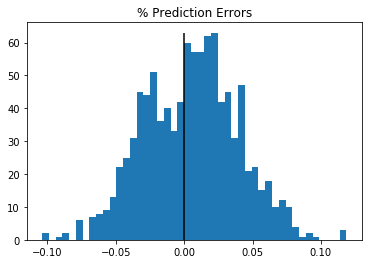

In [19]:
plt.title('% Prediction Errors')
plot = plt.hist((test_df['prediction_mapped']-test_df['open'])/test_df['open'], bins=45)
plt.vlines(0, ymin=0, ymax=plot[0].max())
plt.show()

In [20]:
test_df['transaction'] = 'nothing'
test_df['predicted_change'] = test_df['prediction_mapped'].shift(-1) - test_df['open']
test_df.loc[test_df['predicted_change'] > 0, 'transaction'] = 'buy'
test_df.loc[test_df['predicted_change'] < 0, 'transaction'] = 'sell'

test_df[['open', 'prediction_mapped', 'transaction']].tail(20)

open  prediction_mapped transaction
980  78.45          81.797499         buy
981  80.24          82.103200         buy
982  81.38          82.310541         buy
983  78.00          82.075497         buy
984  79.39          82.274861         buy
985  77.86          81.125884         buy
986  77.70          81.426967         buy
987  78.04          81.189020         buy
988  76.03          81.445240         buy
989  76.72          81.729490         buy
990  75.26          80.422425         buy
991  73.63          79.150949         buy
992  72.45          77.682308         buy
993  70.09          75.677324         buy
994  68.14          74.523365         buy
995  66.87          74.493736         buy
996  66.18          74.031422         buy
997  67.74          73.850819         buy
998  69.18          74.052076         buy
999  68.32          76.294053     nothing

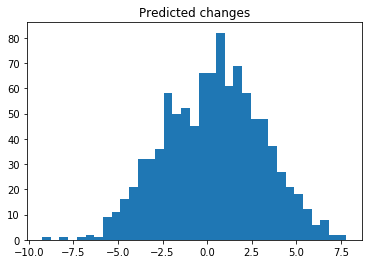

In [21]:
plt.title('Predicted changes')
plt.hist(test_df.loc[test_df['predicted_change'].notnull(), 'predicted_change'], bins=35)
plt.show()

### Long short with kelly criterion

Annualized P/L 0.027019


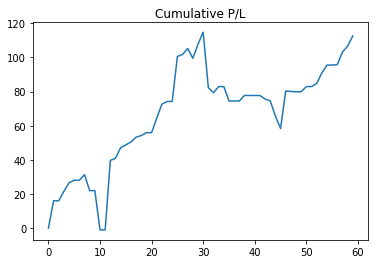

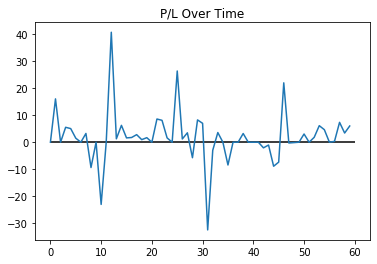

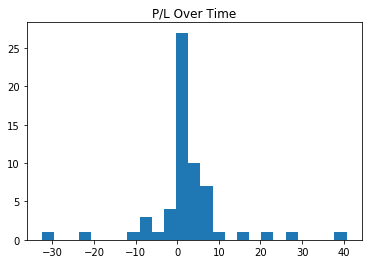

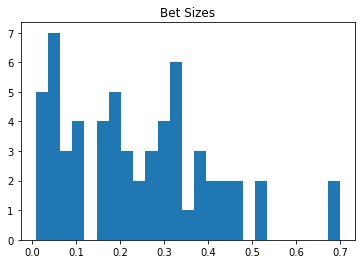

In [22]:
long = False
short = False
profit_loss = [0]
bet_sizes = []
portfolio_size = 1000

for idx, row in test_df.iterrows():
    if row['transaction'] == 'buy' and short:
        n_shares = int((bet_size * portfolio_size)/price)
        profit_loss.append(n_shares * (price - row['open']))
        short = False
    elif row['transaction'] == 'sell' and long:
        n_shares = int((bet_size * portfolio_size)/price)
        profit_loss.append(n_shares * (row['open'] - price))
        long = False
    if not long and not short:
        bet_size = financial_utils.kelly_criterion(abs(row['predicted_change']), 
                                                   np.median(np.abs(profit_loss)), 
                                                   .7, .3)
        if bet_size > 0:
            price = row['open']
            bet_sizes.append(bet_size)
            if row['transaction'] == 'buy':
                long = True
            elif row['transaction'] == 'sell':
                short = True

annualized_return = (1+sum(profit_loss)/portfolio_size)**(1/(len(test_df)/250))-1
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('Cumulative P/L')
plt.plot(np.cumsum(profit_loss))
plt.show()

plt.title('P/L Over Time')
plt.plot(profit_loss)
plt.hlines(0, xmin=0, xmax=len(profit_loss))
plt.show()

plt.title('P/L Over Time')
plt.hist(profit_loss, bins=25)
plt.show()

plt.title('Bet Sizes')
plt.hist(bet_sizes, bins=25)
plt.show()

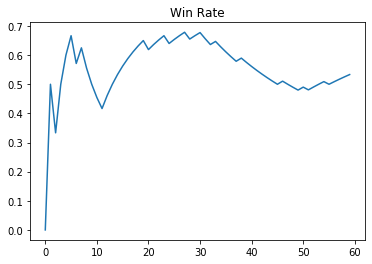

profits  bet_size  win  loss  cumulative_wins  cumulative_losses  win_rate
0      0.00  0.700000    0     1                0                  1  0.000000
1     16.03  0.037686    1     0                1                  1  0.500000
2      0.00  0.700000    0     1                1                  2  0.333333
3      5.52  0.410514    1     0                2                  2  0.500000
4      5.04  0.111675    1     0                3                  2  0.600000
5      1.49  0.049184    1     0                4                  2  0.666667
6     -0.00  0.373720    0     1                4                  3  0.571429
7      3.24  0.288537    1     0                5                  3  0.625000
8     -9.36  0.046865    0     1                5                  4  0.555556
9      0.00  0.426188    0     1                5                  5  0.500000
10   -23.00  0.033524    0     1                5                  6  0.454545
11     0.00  0.523830    0     1                5                  7  0.416667
12    40.67  0.263949    1     0                6                  7  0.461538
13     1.26  0.344846    1     0                7                  7  0.500000
14     6.24  0.105374    1     0                8                  7  0.533333
15     1.60  0.178392    1     0                9                  7  0.562500
16     1.74  0.157819    1     0               10                  7  0.588235
17     2.80  0.436791    1     0               11                  7  0.611111
18     0.95  0.153145    1     0               12                  7  0.631579
19     1.68  0.061128    1     0               13                  7  0.650000

In [23]:
pl = pd.DataFrame(profit_loss, columns=['profits']).join(pd.DataFrame(bet_sizes, columns=['bet_size']))

pl['win'] = 0
pl['loss'] = 0
pl.loc[pl['profits'] > 0, 'win'] = 1
pl.loc[pl['profits'] <= 0, 'loss'] = 1

pl['cumulative_wins'] = pl['win'].cumsum()
pl['cumulative_losses'] = pl['loss'].cumsum()

pl['win_rate'] = pl['cumulative_wins']/(pl['cumulative_wins'] + pl['cumulative_losses'])

plt.title('Win Rate')
plt.plot(pl['win_rate'])
plt.show()

pl.head(20)